In [1]:
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import sqlite3
import time
import hashlib
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib
import editdistance
import functools
from IPython.display import clear_output
import seaborn as sns
import random
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
alldf = pd.read_csv("../tmp_data/inspector_all_openssl.csv")

In [3]:
alldf.sample(1)

,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,library_version
7136,s99e31737a7,49200+49196+49192+49188+49172+49162+49186+49185+163+159+107+106+57+56+49202+49198+49194+49190+49167+49157+157+61+53+49170+49160+49180+49179+22+19+49165+49155+10+49199+49195+49191+49187+49171+49161+49183+49182+162+158+103+64+51+50+154+153+49201+49197+49193+49189+49166+49156+156+60+47+150+49169+49159+49164+49154+5+4+21+18+9+20+17+8+6+3+255,11+10+13+15+21,771,vizio,tv,NaN


In [4]:
alldf['library_version'].value_counts().nlargest(5)

openssl-1.0.2m    64
openssl-1.0.2f    34
openssl-1.1.0l    33
openssl-1.0.1r     8
openssl-1.0.1l     7
Name: library_version, dtype: int64

In [5]:
alldf_sub = alldf.drop_duplicates()

In [6]:
alldf.shape

(11439, 7)

In [7]:
alldf_sub.shape

(11439, 7)

In [8]:
alldf['cipher_code'] = alldf['cipher_suites'].apply(lambda x: x.split("+"))

In [9]:
#alldf.sample(1)

In [10]:
alldf_copy = alldf.fillna("missing").drop_duplicates(['device_id', 'cipher_suites'])
alldf_copy['ciphersuite_len'] = alldf_copy['cipher_code'].apply(lambda x: len(x))
alldf_copy['cipher_code_idxl'] = alldf_copy['cipher_code'].apply(lambda x: ["{}:{}".format(x[i],i) for i in range(len(x))])

In [11]:
alldf_copy['ciphersuite_len'].min()

1

In [12]:
alldf_copy.loc[alldf_copy['ciphersuite_len'] == 1]['device_id'].value_counts().shape

(334,)

In [13]:
#alldf_copy.to_csv("tmp_data/all_cipher_index.csv", index=False)

In [14]:
alldf_copy['groupby_base'] = alldf_copy.index

In [15]:
alldf_exp = alldf_copy.explode('cipher_code_idxl')

In [16]:
alldf_exp["ciphersuite"] = alldf_exp['cipher_code_idxl'].apply(lambda x: hex(int(x.split(":")[0])))
alldf_exp["ciphersuite_pos"] = alldf_exp['cipher_code_idxl'].apply(lambda x: int(x.split(":")[1]))

In [17]:
alldf_exp["ciphersuite_pos"].max()

137

In [18]:
alldf_exp['device_id'].value_counts().shape

(2014,)

In [19]:
cipher_map = pd.read_csv("../ciphersuite_map.csv").rename(columns={"cipher_x": "ciphersuite"})

In [20]:
cipher_map.sample(2)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10
310,0x2c,1,0x00,0x2c,"0x00,0x2c",TLS_PSK_WITH_NULL_SHA,Y,N,[RFC4785],tls_psk,sha,no_cipher,44
278,0x1f,2,0x00,0x1f,"0x00,0x1f",TLS_KRB5_WITH_3DES_EDE_CBC_SHA,Y,N,[RFC2712],tls_krb5,sha,3des_ede_cbc,31


In [21]:
#cipher_map.loc[cipher_map['mac'] == "ccm", 'mac'] = "sha256"

In [22]:
#cipher_map.to_csv("ciphersuite_map.csv", index=False)

In [23]:
alldf_parsed = pd.merge(alldf_exp, cipher_map, how='left', on='ciphersuite')

In [24]:
alldf_parsed['cipher'].value_counts()

aes_128_cbc          40043
aes_256_cbc          38648
aes_128_gcm          24770
aes_256_gcm          23376
3des_ede_cbc         14903
camellia_128_cbc      6593
camellia_256_cbc      6588
chacha20_poly1305     5117
seed_cbc              4828
rc4_128               4440
secure_renego         3229
des_cbc                782
idea_cbc               671
des40_cbc              524
camellia_128_gcm       458
camellia_256_gcm       458
aes_128_ccm            418
aes_128_ccm_8          392
aes_256_ccm            389
aes_256_ccm_8          336
rc4_40                 191
rc2_cbc_40             157
no_cipher              151
aria_256_gcm            45
aria_128_gcm            44
aria_128_cbc            28
aria_256_cbc            26
fallback_scsv           23
des_cbc_40               5
Name: cipher, dtype: int64

In [25]:
alldf_parsed['key_exchange'].value_counts()

tls_dhe_rsa          48648
tls_rsa              33740
tls_ecdhe_ecdsa      25717
tls_dhe_dss          15689
tls_dh_rsa           11578
tls_dh_dss           11574
tls_ecdh_ecdsa       11515
tls_ecdh_rsa         11491
tls_secure_renego     3229
tls_13                2408
tls_psk                508
tls_dh_anon            436
tls_dhe_psk            370
tls_ecdh_anon          234
tls_ecdhe_psk          219
tls_srp_sha_rsa        111
tls_srp_sha_dss        110
tls_fallback            23
tls_krb5_export         14
tls_krb5                14
tls_srp_sha              5
Name: key_exchange, dtype: int64

In [26]:
alldf_parsed['mac'].value_counts()

sha       84260
sha256    57359
sha384    31862
scsv       3252
md5         900
Name: mac, dtype: int64

In [27]:
alldf_parsed = alldf_parsed.fillna("missing")

In [28]:
alldf_filter = alldf_parsed.loc[(alldf_parsed['cipher'] != 'secure_renego') & \
                                (alldf_parsed['cipher'] != 'fallback_scsv') & \
                                (alldf_parsed['key_exchange'] != 'tls_secure_renego') & \
                                (alldf_parsed['key_exchange'] != 'tls_fallback') & \
                                (alldf_parsed['key_exchange'] != 'tls_13') & \
                                (alldf_parsed['key_exchange'] != "missing") & \
                                (alldf_parsed['mac'] != 'scsv') & \
                                (alldf_parsed['device_vendor'] != 'unknown')]

In [29]:
alldf_filter['key_exchange'] = alldf_filter['key_exchange'].apply(lambda x: x.split("_", 1)[-1].upper())
alldf_filter['cipher'] = alldf_filter['cipher'].apply(lambda x: x.upper())
alldf_filter['mac'] = alldf_filter['mac'].apply(lambda x: x.upper())

<ipython-input-29-9a3a5c264d27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_filter['key_exchange'] = alldf_filter['key_exchange'].apply(lambda x: x.split("_", 1)[-1].upper())
<ipython-input-29-9a3a5c264d27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_filter['cipher'] = alldf_filter['cipher'].apply(lambda x: x.upper())
<ipython-input-29-9a3a5c264d27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [30]:
alldf_filter['device_vendor'] = alldf_filter['device_vendor'].apply(lambda x: x.capitalize())

<ipython-input-30-a71617632db0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_filter['device_vendor'] = alldf_filter['device_vendor'].apply(lambda x: x.capitalize())


In [31]:
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Lg')] = 'LG'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Directv')] = 'DirecTV'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Dish network')] = 'Dish Network'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Tcl')] = 'TCL'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Tplink')] = 'TP-Link'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Western digital')] = 'Western Digital'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Hp')] = 'HP'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Ihome')] = 'iHome'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Ikea')] = 'IKEA'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Irobot')] = 'iRobot'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Qnap')] = 'QNAP'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Echobee')] = 'echobee'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Idevices')] = 'iDevices'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Vmware')] = 'VMware'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Ecobee')] = 'ecobee'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'
alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Ubiquity')] = 'Ubiquiti'

<ipython-input-31-bfcccde2ee29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_filter.device_vendor[alldf_filter['device_vendor'].str.contains('Lg')] = 'LG'
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-31-bfcccde2ee29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldf_filter.devic

In [32]:
top_df = alldf_filter.loc[alldf_filter['ciphersuite_pos'] == 0]

In [33]:
dev_total = top_df.groupby('device_vendor')['device_id'].agg('count').reset_index(name='total')

In [34]:
dev_total['total'].sum()

4917

### Top key_exchange methods

In [35]:
keyexchange = top_df.groupby(["key_exchange", "device_vendor"])['ciphersuite'].agg('count')\
                          .reset_index(name='count')

In [36]:
keyexchange["count"].sum()

4917

In [37]:
keyex = pd.merge(keyexchange, dev_total, how='inner', on='device_vendor')

In [38]:
keyex['keyex_perc'] = keyex['count'] / keyex['total']

In [39]:
keyex.loc[(keyex['device_vendor'] == "Google")]

,key_exchange,device_vendor,count,total,keyex_perc
46,DHE_RSA,Google,96,505,0.190099
47,ECDHE_ECDSA,Google,347,505,0.687129
48,PSK,Google,5,505,0.009901
49,RSA,Google,57,505,0.112871


In [40]:
top_keyex_reshape = keyex.pivot(index='key_exchange', columns='device_vendor', values='keyex_perc')

In [41]:
top_keyex_reshape = top_keyex_reshape.fillna(0)

In [42]:
top_keyex_reshape_cp = top_keyex_reshape.copy()

In [43]:
mask = np.zeros_like(top_keyex_reshape_cp)

In [44]:
top_keyex_reshape_mask = (top_keyex_reshape_cp == 0).values

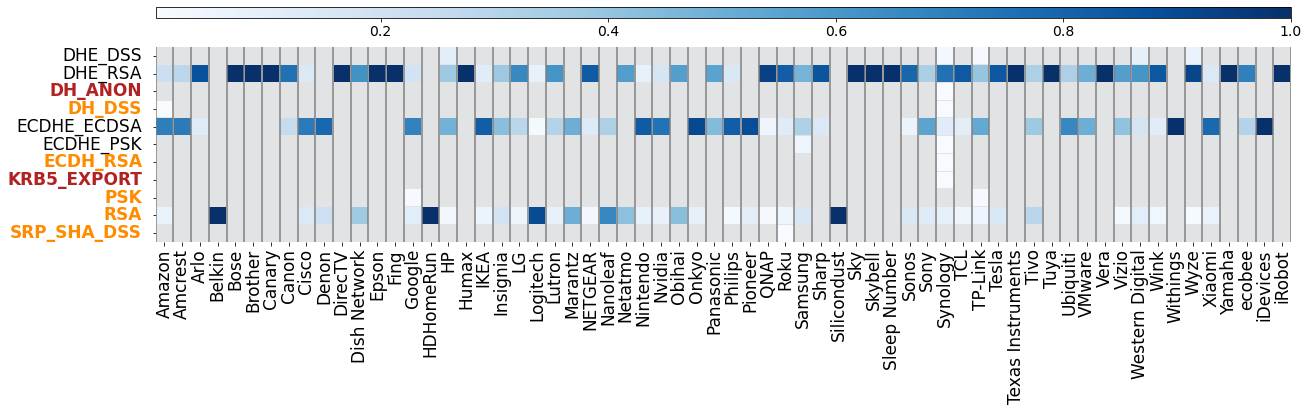

In [45]:
fig, (cax, ax) = plt.subplots(nrows=2, figsize=(19, 5.7), gridspec_kw={"height_ratios":[0.05, 1]})
ax = sns.heatmap(top_keyex_reshape_cp, cmap="Blues", ax=ax, square=True, cbar=False, linecolor='#E1E3E5', mask = top_keyex_reshape_mask, linewidths=.1)

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=14) 


ax.set_facecolor("#E1E3E5")
for pos in range(0, 67, 1):
    ax.vlines(ymin=0, ymax=11, x=pos, color='gray')
#ax.set_facecolor(((0.0, 0.0, 0.0, 0.3)))

#fig.colorbar(ax.get_children()[0], cax=cax, fraction=0.046, pad=0.04, orientation="horizontal")

plt.ylabel("")
plt.xlabel("")

weak_lis = [3,6,8,9,10]
for idx in weak_lis:
    ax.get_yticklabels()[idx].set_color("darkorange")
    ax.get_yticklabels()[idx].set_fontweight('bold')
insecure_lis = [2,7]
for idx in insecure_lis:
    ax.get_yticklabels()[idx].set_color("firebrick")
    ax.get_yticklabels()[idx].set_fontweight('bold')
    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, ha='center', va='top')
ax.tick_params(axis="y",direction="out", pad=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=17, va='center')


plt.subplots_adjust(left=0.15, right=0.98, bottom=0.4, top=0.99)
#fig.tight_layout()
#fig.savefig("/Users/hongyingdong/Documents/iot-study/figures/dev_issuer_overview.png", dpi="figure")
fig.savefig("/Users/hongyingdong/Documents/iot-study/iot-client/fps/figures/comp_keyexchange", dpi=150)

plt.show()

### Top ciphers

In [46]:
cipher = top_df.groupby(["cipher", "device_vendor"])['ciphersuite'].agg('count')\
                                     .reset_index(name='count')

In [47]:
cipher = pd.merge(cipher, dev_total, how='inner', on='device_vendor')

In [48]:
cipher['cipher_perc'] = cipher['count'] / cipher['total']

In [49]:
cipher.loc[(cipher['device_vendor'] == "Amazon")]

,cipher,device_vendor,count,total,cipher_perc
35,AES_128_CBC,Amazon,203,1826,0.111172
36,AES_128_GCM,Amazon,967,1826,0.529573
37,AES_256_CBC,Amazon,29,1826,0.015882
38,AES_256_GCM,Amazon,608,1826,0.332968
39,CHACHA20_POLY1305,Amazon,10,1826,0.005476
40,RC4_128,Amazon,9,1826,0.004929


In [50]:
top_cipher_reshape = cipher.pivot(index='cipher', columns='device_vendor', values='cipher_perc')

In [51]:
top_cipher_reshape = top_cipher_reshape.fillna(0)

In [52]:
top_cipher_reshape_cp = top_cipher_reshape.copy()

In [53]:
mask_cipher = np.zeros_like(top_cipher_reshape_cp)

In [54]:
top_cipher_reshape_mask = (top_cipher_reshape_cp == 0).values

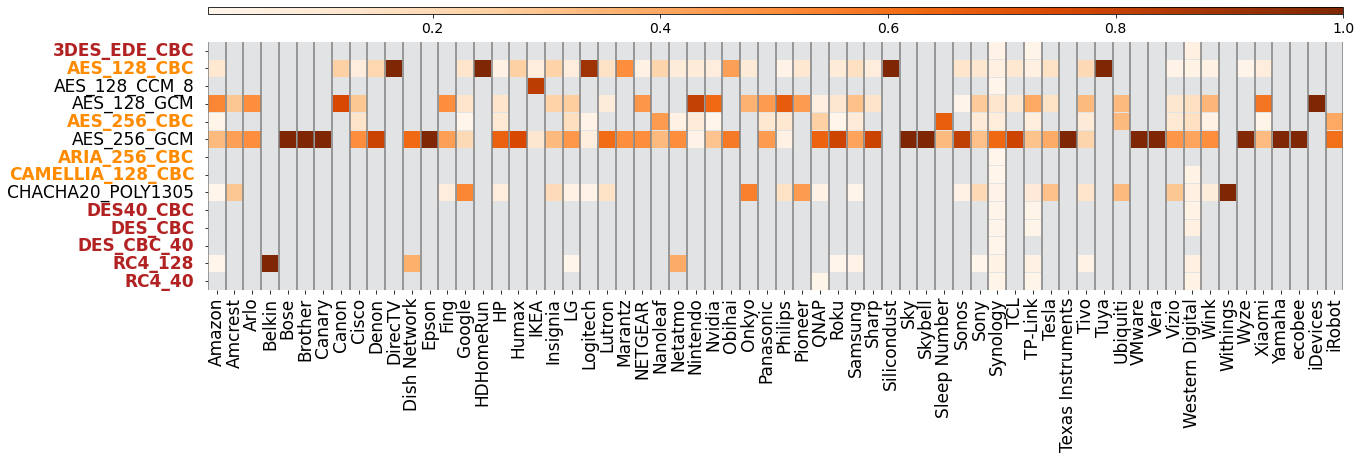

In [55]:
fig, (cax, ax) = plt.subplots(nrows=2, figsize=(19, 7.2), gridspec_kw={"height_ratios":[0.03, 1]})
ax = sns.heatmap(top_cipher_reshape_cp, cmap="Oranges", ax=ax, square=True, cbar=False, linecolor='#E1E3E5', mask = top_cipher_reshape_mask, linewidths=.1)

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=14) 


ax.set_facecolor("#E1E3E5")
for pos in range(0, 67, 1):
    ax.vlines(ymin=0, ymax=18, x=pos, color='gray')
#ax.set_facecolor(((0.0, 0.0, 0.0, 0.3)))

#fig.colorbar(ax.get_children()[0], cax=cax, fraction=0.046, pad=0.04, orientation="horizontal")

plt.ylabel("")
plt.xlabel("")

weak_lis = [1,4,6,7]
for idx in weak_lis:
    ax.get_yticklabels()[idx].set_color("darkorange")
    ax.get_yticklabels()[idx].set_fontweight('bold')
insecure_lis = [0,9,10,11,12,13]
for idx in insecure_lis:
    ax.get_yticklabels()[idx].set_color("firebrick")
    ax.get_yticklabels()[idx].set_fontweight('bold')
    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, ha='center', va='top')
ax.tick_params(axis="y",direction="out", pad=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=17, va='center')

#fig.tight_layout()
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.35, top=0.90)
#fig.savefig("/Users/hongyingdong/Documents/iot-study/figures/dev_issuer_overview.png", dpi="figure")
fig.savefig("/Users/hongyingdong/Documents/iot-study/iot-client/fps/figures/comp_cipher", dpi=150)

plt.show()

### Top mac

In [56]:
mac = top_df.groupby(["mac", "device_vendor"])['ciphersuite'].agg('count')\
                                     .reset_index(name='count')

In [57]:
mac = pd.merge(mac, dev_total, how='inner', on='device_vendor')

In [58]:
mac['mac_perc'] = mac['count'] / mac['total']

In [59]:
mac.loc[(mac['device_vendor'] == "Amazon")]

,mac,device_vendor,count,total,mac_perc
31,SHA,Amazon,229,1826,0.125411
32,SHA256,Amazon,977,1826,0.535049
33,SHA384,Amazon,620,1826,0.339540


In [67]:
mac.loc[mac.mac=='SHA', 'mac'] = 'SHA-1'

In [68]:
top_mac_reshape = mac.pivot(index='mac', columns='device_vendor', values='mac_perc')

In [69]:
top_mac_reshape = top_mac_reshape.fillna(0)

In [70]:
top_mac_reshape_cp = top_mac_reshape.copy()

In [71]:
mask_mac = np.zeros_like(top_mac_reshape_cp)

In [72]:
top_mac_reshape_mask = (top_mac_reshape_cp == 0).values

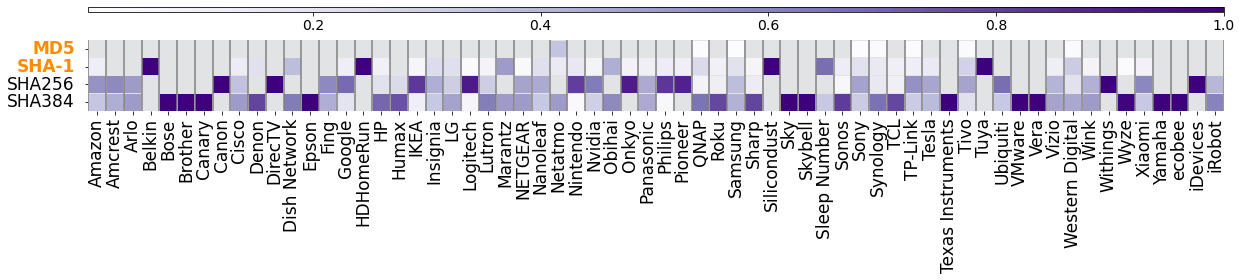

In [73]:
fig, (cax, ax) = plt.subplots(nrows=2, figsize=(19, 4.2), gridspec_kw={"height_ratios":[0.05, 1]})
ax = sns.heatmap(top_mac_reshape_cp, cmap="Purples", ax=ax, square=True, cbar=False, linecolor='#E1E3E5', mask = top_mac_reshape_mask, linewidths=.1)

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=14) 


ax.set_facecolor("#E1E3E5")
for pos in range(0, 67, 1):
    ax.vlines(ymin=0, ymax=13, x=pos, color='gray')
#ax.set_facecolor(((0.0, 0.0, 0.0, 0.3)))

#fig.colorbar(ax.get_children()[0], cax=cax, fraction=0.046, pad=0.04, orientation="horizontal")

plt.ylabel("")
plt.xlabel("")

weak_lis = [0,1]
for idx in weak_lis:
    ax.get_yticklabels()[idx].set_color("darkorange")
    ax.get_yticklabels()[idx].set_fontweight('bold')
insecure_lis = []
for idx in insecure_lis:
    ax.get_yticklabels()[idx].set_color("firebrick")
    ax.get_yticklabels()[idx].set_fontweight('bold')
    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, ha='center', va='top')
ax.tick_params(axis="y",direction="out", pad=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=17, va='center')

#fig.tight_layout()
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.5, top=0.90)
#fig.savefig("/Users/hongyingdong/Documents/iot-study/figures/dev_issuer_overview.png", dpi="figure")
fig.savefig("/Users/hongyingdong/Documents/iot-study/iot-client/fps/figures/comp_mac", dpi=150)

plt.show()

### Lowest index of ciphersuites containing weak algorithms

In [405]:
#parsed_100t.sample(1)

In [230]:
parsed_100t['mac'].value_counts().nlargest(10)

sha          113466
sha256        75249
sha384        42901
md5            1064
not_found       941
Name: mac, dtype: int64

In [406]:
weak_keyex = ['tls_rsa', 'tls_dh', 'tls_ecdh']
weak_cipher = ['aes_128_cbc', 'aes_256_cbc', '3des_ede_cbc', 'camellia_128_cbc', 'camellia_256_cbc', 'rc4_128', 'seed_cbc']
weak_mac = ['sha', 'md5']

In [407]:
parsed_100t['if_weak'] = parsed_100t.apply(lambda x: True if ((x['key_exchange'] in weak_keyex) | \
                                                              (x['cipher'] in weak_cipher) | \
                                                              (x['mac'] in weak_mac)) else False, axis=1)

<ipython-input-407-7570af7165cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_100t['if_weak'] = parsed_100t.apply(lambda x: True if ((x['key_exchange'] in weak_keyex) | \


In [411]:
parsed_100t.loc[(parsed_100t['if_weak'] == True) & (parsed_100t['ciphersuite_pos'] == 0)]['device_vendor'].value_counts().shape

(48,)

In [412]:
parsed_100t_weak = parsed_100t.loc[parsed_100t['if_weak'] == True]

In [413]:
parsed_100t_weak.groupby(['device_vendor'])['ciphersuite_pos'].agg('min').reset_index(name='highest_idx')

,device_vendor,highest_idx
0,amazon,0
1,amcrest,1
2,arlo,2
3,belkin,0
4,bose,2
...,...,...
61,wink,0
62,withings,5
63,wyze,0
64,xiaomi,0


In [414]:
parsed_100t_weak['ciphersuite_pos'].value_counts().shape

(112,)

In [423]:
parsed_100tsub = parsed_100t_weak.drop_duplicates(subset=["device_vendor", "ciphersuite_pos"])

In [433]:
parsed_100tsub_highest = parsed_100tsub.groupby(['device_vendor'])['ciphersuite_pos'].agg("min").reset_index(name='highest_idx')

In [455]:
parsed_100tsub_highest

,device_vendor,highest_idx
0,amazon,0
1,amcrest,1
2,arlo,2
3,belkin,0
4,bose,2
...,...,...
61,wink,0
62,withings,5
63,wyze,0
64,xiaomi,0


In [460]:
parsed_100tsub["ciphersuite_pos_addone"] = parsed_100tsub["ciphersuite_pos"] + 1

<ipython-input-460-228d4ba3b716>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parsed_100tsub["ciphersuite_pos_addone"] = parsed_100tsub["ciphersuite_pos"] + 1


In [461]:
parsed_100tsub_m = parsed_100tsub.merge(parsed_100tsub_highest, on="device_vendor", how="left")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 [Text(0, 0, 'amazon'),
  Text(1, 0, 'google'),
  Text(2, 0, 'obihai'),
  Text(3, 0, 'synology'),
  Text(4, 0, 'nvidia'),
  Text(5, 0, 'tplink'),
  Text(6, 0, 'panasonic'),
  Text(7, 0, 'lutron'),
  Text(8, 0, 'samsung'),
  Text(9, 0, 'roku'),
  Text(10, 0, 'dish network'),
  Text(11, 0, 'wyze'),
  Text(12, 0, 'sonos'),
  Text(13, 0, 'logitech'),
  Text(14, 0, 'wink'),
  Text(15, 0, 'pioneer'),
  Text(16, 0, 'idevices'),
  Text(17, 0, 'epson'),
  Text(18, 0, 'sony'),
  Text(19, 0, 'ecobee'),
  Text(20, 0, 'irobot'),
  Text(21, 0, 'philips'),
  Text(22, 0, 'texas instruments'),
  Text(23, 0, 'tcl'),
  Text(24, 0, 'qnap'),
  Text(25, 0, 'tivo'),
  Text(26, 0, 'nintendo'),
  Text(27, 0, 'fing'),


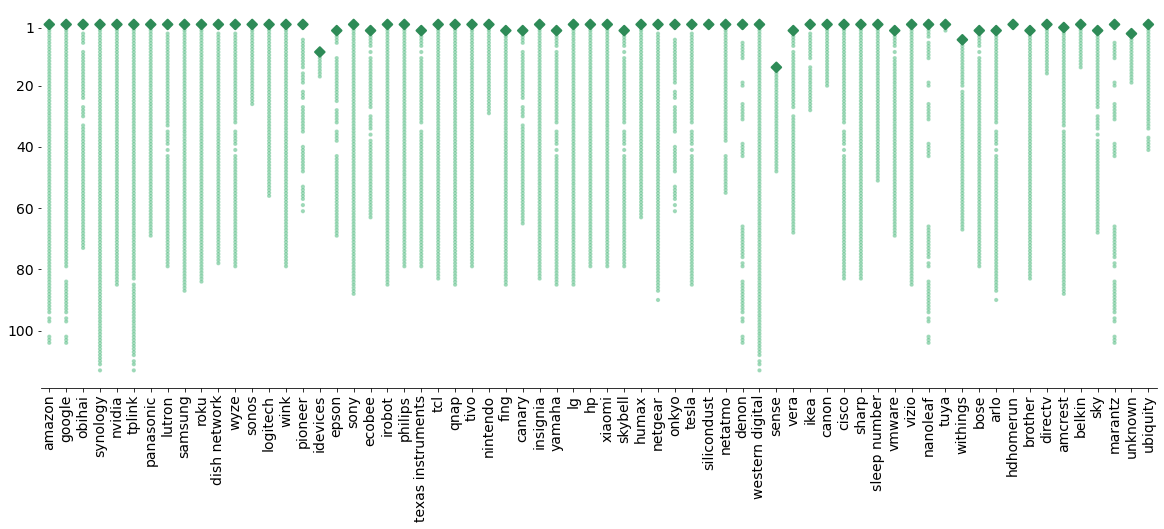

In [467]:
fig = plt.subplots(figsize=(20, 7))
sns.despine(right=True, left=True)

ax = sns.scatterplot(x="device_vendor", y="ciphersuite_pos_addone", data=parsed_100tsub_m, \
                   color="mediumseagreen", alpha=.5, size=13)

ax2 = sns.pointplot(x="device_vendor", y="highest_idx", data=parsed_100tsub_m.drop_duplicates(["device_vendor"]), \
                    join=False, color="seagreen", 
                    markers="D", scale=1)

ax.invert_yaxis()
ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("")
plt.yticks([1, 20, 40, 60, 80, 100], fontsize=14)
plt.xticks(rotation=90, fontsize=14)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14.5, ha='center', va='top')
#ax.tick_params(axis="y",direction="out", pad=10)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, va='center')